# CarRacing with VAE

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/Artificial Intelligence/World Models/WorldModels")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install Box2D
!pip install ConfigArgParse
import os
import numpy as np
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])

     |████████████████████████████████| 1.3MB 7.5MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
  Created wheel for ConfigArgParse: filename=ConfigArgParse-1.4-cp37-none-any.whl size=19638 sha256=8f6235fc8207455590d68ad087ca3a10f387f7d88fdcedbf2a5392869b22bdde
  Stored in directory: /root/.cache/pip/wheels/d6/61/f7/626bbd080a9f2f70015f92025e0af663c595146083f3d9aa05
Successfully built ConfigArgParse


In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [5]:
filelist = os.listdir(DATA_DIR)

In [6]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [7]:
obs.shape

(226, 64, 64, 3)

In [8]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [9]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

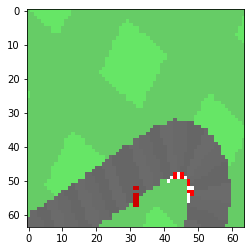

In [10]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [11]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-1.1724  1.5206  0.5269 -1.5525 -0.202   0.6831  3.4334  0.5044 -0.319   2.3544 -0.8611  0.2837
  0.437   1.4237 -0.3748  0.7499 -1.371   0.1398 -2.0728 -1.9345 -0.4462 -0.0204 -0.6778  1.5781
 -1.3583  1.5888  0.8853  1.1011 -1.3549  2.0404  2.0903 -0.4122], shape=(32,), dtype=float32)


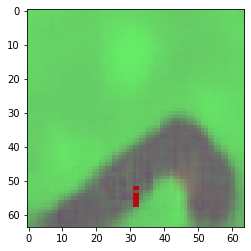

In [12]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

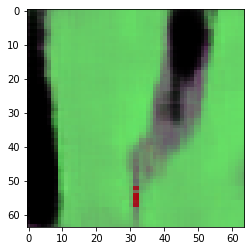

In [13]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Return Plot for Controller

In [14]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.4.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))
og_filepath = os.path.join('results/og/log', 'carracing.cma.16.64.hist_best.json')
with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
with open(og_filepath, 'r') as f:
  og_data = json.load(f)

eager_data = np.array(eager_data)
og_data = np.array(og_data)

eager_comparison_max = eager_data[-1, 0] # b/c we didnt run for 2k
og_max_idx = np.sum(np.array(og_data[: ,0],dtype=np.float) <= eager_comparison_max)
print(og_max_idx)

og_data = np.array(og_data)[:og_max_idx]

4


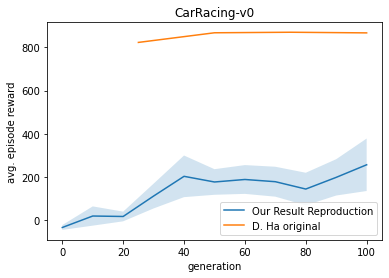

In [15]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]

og_x = np.array(og_data[:, 0], dtype=np.float)
og_ret = np.array(og_data[:, 5], dtype=np.float)
# don't have access to standard deviation of the og evaluation

plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(eager_x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(og_x, og_ret)

plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['Our Result Reproduction', 'D. Ha original'])